In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric
import torch
print(torch.__version__)  
print(torch.version.cuda)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 18 kB/s 
     |████████████████████████████████| 21.0 MB 106.8 MB/s 
     |████████████████████████████████| 2.9 MB 62.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

1.11.0+cu102
10.2


In [ ]:
# load ComBat algorithm
# !python /content/drive/MyDrive/ABIDE/neuralCombat.py 
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
# from neuralCombat.py import neuralCombat
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net

def initialize():
  set_seed


def set_seed(seed=0):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# initialize()

In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat = True    # True or False
scaler = True

if combat == False:
  save_combat = '/without_ComBat/'
else:
  save_combat = '/with_ComBat/'

save_path = '/content/drive/MyDrive/ABIDE/save_models/'+fMRI_atlas+ save_combat
root_path = '/content/dataset'
if os.path.exists(root_path):
  shutil.rmtree(root_path) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

k_fold = 5
new_number_features = 5000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  print(subject_name)
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]].replace(' ', ''))
    position = position + 1
if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)
	print('Done')

constructing fMRI features
50003
50004
50005
50006
50007
50008
50010
50011
50012
50013
50014
50015
50016
50020
50022
50023
50024
50025
50026
50027
50028
50030
50031
50032
50033
50034
50035
50036
50037
50038
50039
50040
50041
50042
50043
50044
50045
50046
50047
50048
50049
50050
50051
50052
50053
50054
50056
50057
50059
50060
50102
50103
50104
50105
50106
50107
50109
50111
50112
50113
50114
50115
50116
50117
50118
50119
50121
50123
50124
50125
50127
50128
50129
50130
50131
50132
50134
50135
50142
50143
50144
50145
50146
50147
50148
50149
50150
50152
50153
50156
50157
50158
50159
50160
50161
50162
50163
50164
50167
50168
50169
50170
50171
50182
50183
50184
50186
50187
50188
50189
50190
50193
50194
50195
50196
50198
50199
50200
50201
50202
50203
50204
50205
50206
50208
50210
50213
50214
50215
50217
50232
50233
50234
50236
50237
50239
50240
50241
50243
50245
50247
50248
50249
50250
50251
50252
50253
50254
50255
50257
50259
50260
50261
50262
50263
50264
50265
50266
50267
50268
50269
50270
5

In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################
if combat == True:
	batch = []
	for i in range(len(sites)):
		batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

	combat_labels = []
	combat_genders = []
	combat_ages = []
	for i in range(len(labels)):
		combat_labels.append(labels[i] + 1)
		combat_genders.append(genders[i])
		combat_ages.append(ages[i])

	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
										  covars=covars,
										  batch_col=batch_col,
										  categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1

In [ ]:
import torch.nn as nn
import torch_geometric as tg

############################################### GCN model ###############################################################
############################################### GCN model ###############################################################
############################################### GCN model ###############################################################
class GCN(nn.Module):
    def __init__(self, in_c, hid_c, out_c, K, dropout_rate, normalize=True):
        """
        :param in_c: int, number of input channels.
        :param hid_c: int, number of hidden channels.
        :param out_c: int, number of output channels.
        :param K:
        """
        super(GCN, self).__init__()
        self.normalize = normalize

        self.conv1 = tg.nn.ChebConv(in_c, hid_c, K, normalization='sym', bias=True)
        self.conv2 = tg.nn.ChebConv(hid_c, hid_c, K, normalization='sym', bias=True)
        self.conv3 = tg.nn.ChebConv(hid_c, out_c, K, normalization='sym', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.softmax = nn.LogSoftmax(dim=1)


    def forward(self, data, edge_index, edgenet_input):

        edge_weight = torch.squeeze(edgenet_input)
        # data = self.dropout(data)
        h = self.relu(self.dropout(self.conv1(data, edge_index, edge_weight)))
        h = self.relu(self.dropout(self.conv2(h, edge_index, edge_weight)))
        h = self.conv3(h, edge_index, edge_weight)

        return self.softmax(h)

In [ ]:
############################################### Population graph ###############################################################
############################################### Population graph ###############################################################
############################################### Population graph ###############################################################
def get_subject_score(subject_list,l, path, all_subject_list):

    name = l + '.mat'
    file = scio.loadmat(os.path.join(path, name))
    file = file[l]
    label_dict = {}
    for i in subject_list:
        sample_index = get_index(lst=all_subject_list, item=i)
        value = file[sample_index[0]]
        if l == 'genders':
            label_dict[i] = int(value)
        elif l == 'ages':
            label_dict[i] = float(value)
        elif l == 'FIQS':
            label_dict[i] = float(value)
        elif l == 'NUM':
            label_dict[i] = int(value)
        elif l == 'PEC':
            label_dict[i] = float(value)
        elif l == 'RAT':
            label_dict[i] = int(value)
        elif l == 'sites':
            label_dict[i] = value.replace(' ', '')
        else:
            label_dict[i] = value
    return label_dict

def create_graph_from_scores(scores, subject_list, path, all_subject_list):
    """
        scores       : list of phenotypic information to be used to construct the affinity graph
        subject_list : list of subject IDs
    return:
        graph        : adjacency matrix of the population graph (num_subjects x num_subjects)
    """

    num_nodes = len(subject_list)
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = get_subject_score(subject_list, l, path, all_subject_list)

        # quantitative phenotypic scores
        if l in ['ages']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass
        elif l in ['FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[subject_list[k]]) - float(label_dict[subject_list[j]]))
                        if val < 10:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[subject_list[k]] == label_dict[subject_list[j]]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

GCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        GCN_labels[i,0] = 1
    else:
        GCN_labels[i,1] = 1


all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    subject_IDs.remove(i)

graph = create_graph_from_scores(['sites'], subject_IDs, label_dir,all_subject_IDs)



In [ ]:
data = {}
for fold in range(1, k_fold+1):
  data[str(fold)] = []
  selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
  fold_data = selector.transform(fMRI_images)

  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 1], dtype=np.float32) 
  aff_score = np.zeros(num_edge, dtype=np.float32)
  flatten_ind = 0

  for i in range(n): 
    for j in range(n):
      edge_index[:, flatten_ind] = [i, j]
      edgenet_input[flatten_ind] = graph[i,j]
      aff_score[flatten_ind] = graph[i,j]
      flatten_ind += 1


  keep_ind = np.where(aff_score > 0.99)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]

  data[str(fold)].append(fold_data)
  data[str(fold)].append(GCN_labels)
  data[str(fold)].append(edge_index)
  data[str(fold)].append(edgenet_input)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_GCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=True)
    edgenet_input = edgenet_input.float()
    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    scheduler.zero_grad()
    out = model(data, edge_index, edgenet_input)
    out = out[fold_train_index,:]  
    target = target[fold_train_index, :]

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1]) # only train set will be included
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    cross_loss.backward()
    scheduler.step()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_GCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_GCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss

    
def validation_GCN(args, model,all_data,  fold_validation_index):

    model.eval()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out = model(data, edge_index, edgenet_input)
    out = out[fold_validation_index, :]
    target = target[fold_validation_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()


def test_GCN(args, model, all_data,  fold_test_index):

    model.eval()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out = model(data, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    return target, out, out_prob, cross_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################

parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--weight-decay', '--wd', default=1e-8, type=float,
                    metavar='W', help='weight decay (default: 1e-8)')
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--lr', type=str, default=8e-4)
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--cheby_order_K', type=int, default=2)
parser.add_argument('--input_dimension', type=int, default=new_number_features)
parser.add_argument('--hidden_dimension', type=int, default=128)
parser.add_argument('--output_dimension', type=int, default=2)
parser.add_argument('--dropout_rate', type=int, default=0.3)
#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
gpu_ids = range(args.ngpu)
train = train_GCN


  + Number of params: 1313538
Save models
Train Epoch: 1: train loss : 1.16977239	 train accuracy : 0.51467710	 val accuracy : 0.48351648	 test accuracy : 0.48587571	
Save models
Train Epoch: 2: train loss : 1.71666336	 train accuracy : 0.49119374	 val accuracy : 0.52747253	 test accuracy : 0.51977401	
Save models
Train Epoch: 3: train loss : 2.03753877	 train accuracy : 0.56751468	 val accuracy : 0.58241758	 test accuracy : 0.58192090	
Train Epoch: 4: train loss : 0.93484962	 train accuracy : 0.68493151	 val accuracy : 0.54945055	 test accuracy : 0.52542373	
Train Epoch: 5: train loss : 1.28348386	 train accuracy : 0.61056751	 val accuracy : 0.54945055	 test accuracy : 0.53672316	
Save models
Train Epoch: 6: train loss : 1.12671125	 train accuracy : 0.64579256	 val accuracy : 0.70329670	 test accuracy : 0.71751412	
Train Epoch: 7: train loss : 0.66851091	 train accuracy : 0.75538160	 val accuracy : 0.61538462	 test accuracy : 0.61016949	
Train Epoch: 8: train loss : 0.70039153	 train 

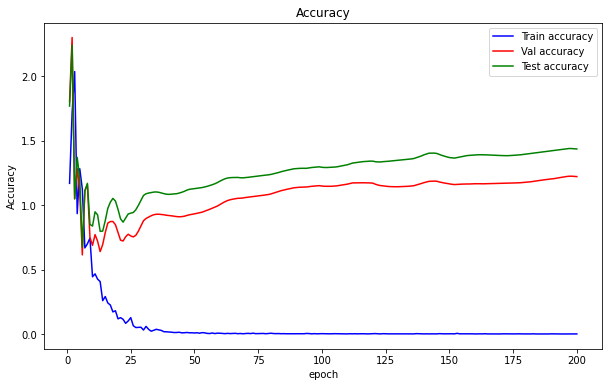

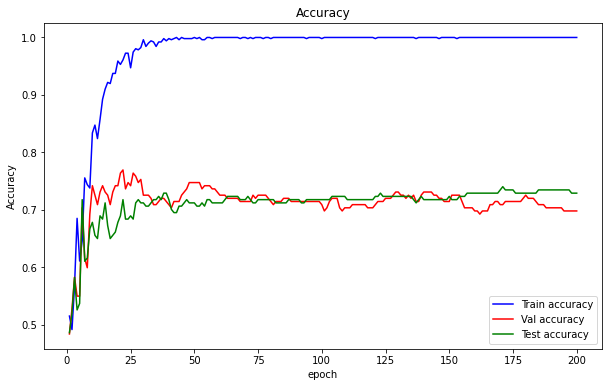



In fold  1
The best validaiton accuracy is:  0.7692307692307693
Happened at epoch:  22
The corresponding test accuracy 0.7175141242937854
The corresponding test AUC is:  0.7676470588235295




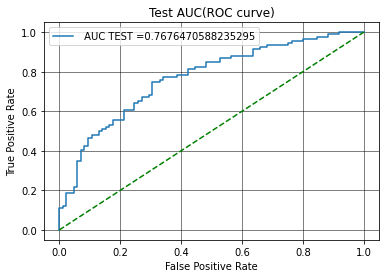

  + Number of params: 1313538
Save models
Train Epoch: 1: train loss : 1.57163322	 train accuracy : 0.46242775	 val accuracy : 0.51412429	 test accuracy : 0.56321839	
Train Epoch: 2: train loss : 1.11254823	 train accuracy : 0.57418112	 val accuracy : 0.49152542	 test accuracy : 0.47126437	
Save models
Train Epoch: 3: train loss : 2.68704939	 train accuracy : 0.47784200	 val accuracy : 0.58192090	 test accuracy : 0.52873563	
Train Epoch: 4: train loss : 0.78033900	 train accuracy : 0.68208092	 val accuracy : 0.51977401	 test accuracy : 0.53448276	
Train Epoch: 5: train loss : 1.53259277	 train accuracy : 0.59152216	 val accuracy : 0.54237288	 test accuracy : 0.54597701	
Save models
Train Epoch: 6: train loss : 1.03588831	 train accuracy : 0.62813102	 val accuracy : 0.59887006	 test accuracy : 0.61494253	
Train Epoch: 7: train loss : 0.55601293	 train accuracy : 0.79190751	 val accuracy : 0.58757062	 test accuracy : 0.55747126	
Train Epoch: 8: train loss : 0.77780724	 train accuracy : 0

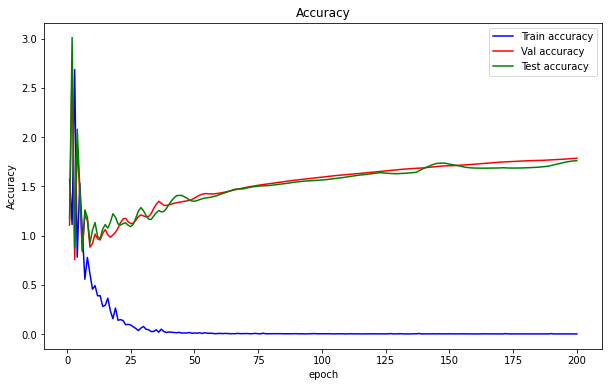

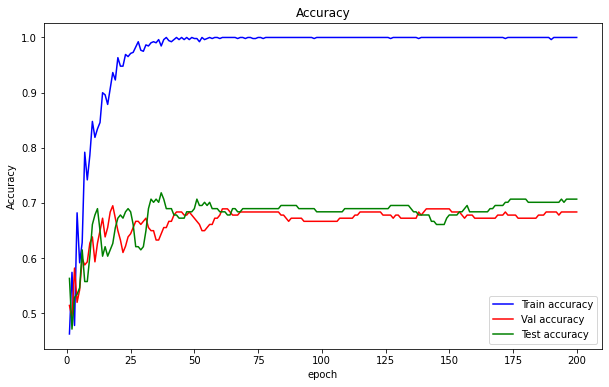



In fold  2
The best validaiton accuracy is:  0.6949152542372882
Happened at epoch:  18
The corresponding test accuracy 0.6264367816091954
The corresponding test AUC is:  0.6856498075136068




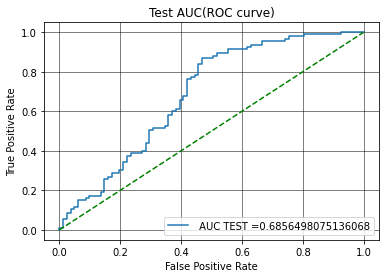

  + Number of params: 1313538
Save models
Train Epoch: 1: train loss : 1.04275239	 train accuracy : 0.55133080	 val accuracy : 0.48275862	 test accuracy : 0.45294118	
Save models
Train Epoch: 2: train loss : 1.32001352	 train accuracy : 0.53041825	 val accuracy : 0.54022989	 test accuracy : 0.55294118	
Save models
Train Epoch: 3: train loss : 1.48008370	 train accuracy : 0.59125475	 val accuracy : 0.63218391	 test accuracy : 0.54117647	
Train Epoch: 4: train loss : 0.75353754	 train accuracy : 0.71482890	 val accuracy : 0.54597701	 test accuracy : 0.51176471	
Train Epoch: 5: train loss : 1.05943954	 train accuracy : 0.67490494	 val accuracy : 0.56321839	 test accuracy : 0.52941176	
Train Epoch: 6: train loss : 0.75532579	 train accuracy : 0.73003802	 val accuracy : 0.62068966	 test accuracy : 0.60588235	
Save models
Train Epoch: 7: train loss : 0.43369618	 train accuracy : 0.84030418	 val accuracy : 0.64942529	 test accuracy : 0.67058824	
Save models
Train Epoch: 8: train loss : 0.4355

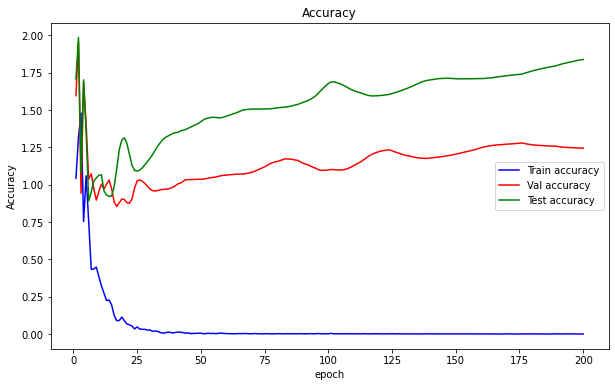

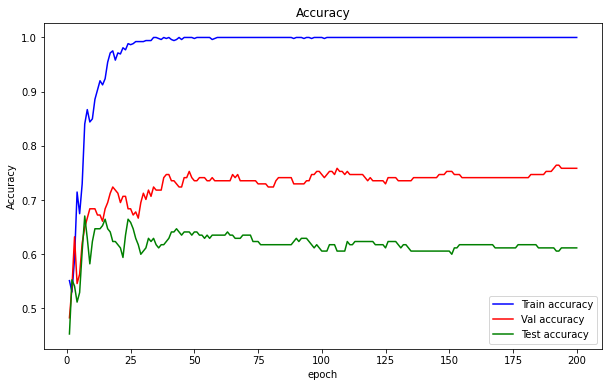



In fold  3
The best validaiton accuracy is:  0.764367816091954
Happened at epoch:  193
The corresponding test accuracy 0.6058823529411764
The corresponding test AUC is:  0.679941209406495




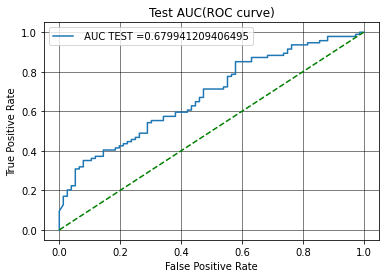

  + Number of params: 1313538
Save models
Train Epoch: 1: train loss : 1.02652729	 train accuracy : 0.47842402	 val accuracy : 0.51764706	 test accuracy : 0.50898204	
Save models
Train Epoch: 2: train loss : 1.83643174	 train accuracy : 0.53095685	 val accuracy : 0.58823529	 test accuracy : 0.57485030	
Train Epoch: 3: train loss : 0.83508968	 train accuracy : 0.63039400	 val accuracy : 0.51176471	 test accuracy : 0.60479042	
Train Epoch: 4: train loss : 0.91790390	 train accuracy : 0.69043152	 val accuracy : 0.54117647	 test accuracy : 0.59880240	
Save models
Train Epoch: 5: train loss : 0.70294797	 train accuracy : 0.71669794	 val accuracy : 0.62352941	 test accuracy : 0.67065868	
Save models
Train Epoch: 6: train loss : 0.49047223	 train accuracy : 0.79924953	 val accuracy : 0.67058824	 test accuracy : 0.66467066	
Train Epoch: 7: train loss : 0.44871858	 train accuracy : 0.81801126	 val accuracy : 0.63529412	 test accuracy : 0.64670659	
Save models
Train Epoch: 8: train loss : 0.5542

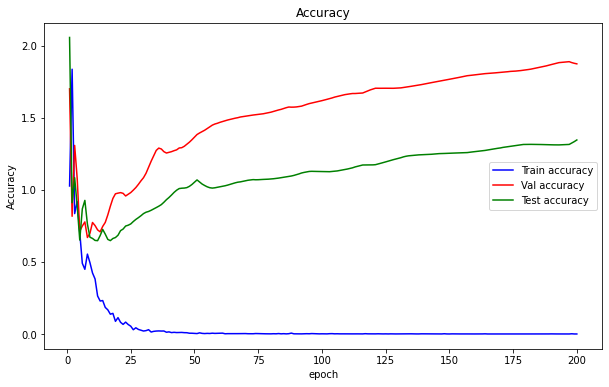

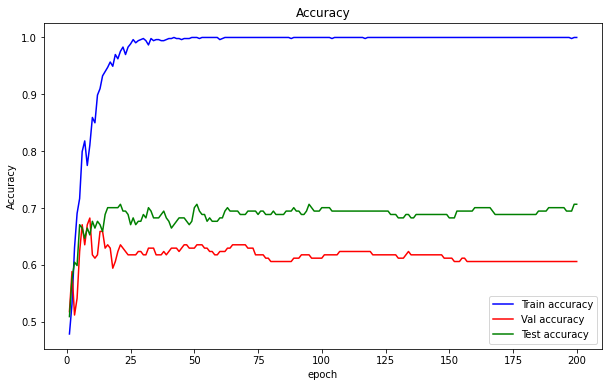



In fold  4
The best validaiton accuracy is:  0.6823529411764706
Happened at epoch:  9
The corresponding test accuracy 0.6526946107784432
The corresponding test AUC is:  0.7391304347826088




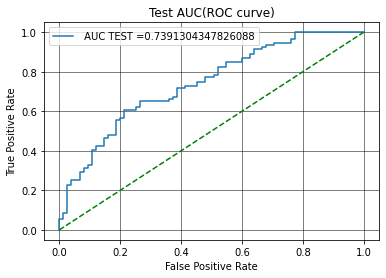

  + Number of params: 1313538
Save models
Train Epoch: 1: train loss : 1.06964958	 train accuracy : 0.47984645	 val accuracy : 0.57485030	 test accuracy : 0.53296703	
Train Epoch: 2: train loss : 1.76474977	 train accuracy : 0.58157390	 val accuracy : 0.46706587	 test accuracy : 0.49450549	
Save models
Train Epoch: 3: train loss : 2.12097955	 train accuracy : 0.53934741	 val accuracy : 0.60479042	 test accuracy : 0.57142857	
Train Epoch: 4: train loss : 0.74856496	 train accuracy : 0.69865643	 val accuracy : 0.56886228	 test accuracy : 0.55494505	
Save models
Train Epoch: 5: train loss : 1.16034925	 train accuracy : 0.61996161	 val accuracy : 0.60479042	 test accuracy : 0.56043956	
Save models
Train Epoch: 6: train loss : 1.00104094	 train accuracy : 0.66986564	 val accuracy : 0.67065868	 test accuracy : 0.65384615	
Train Epoch: 7: train loss : 0.49740595	 train accuracy : 0.79078695	 val accuracy : 0.58682635	 test accuracy : 0.63736264	
Train Epoch: 8: train loss : 0.55939710	 train 

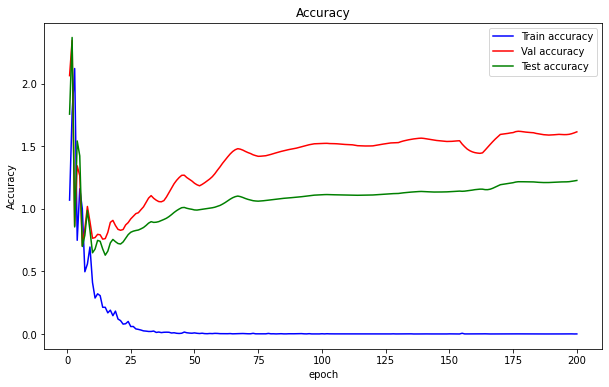

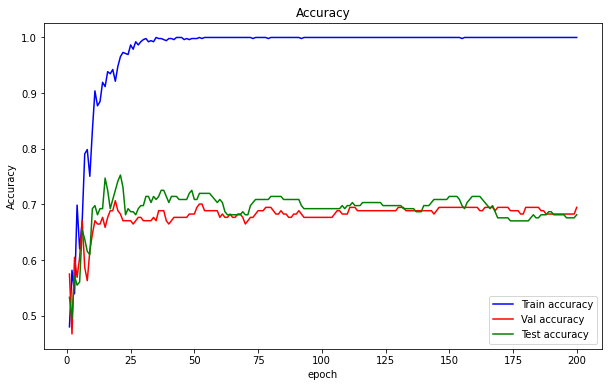



In fold  5
The best validaiton accuracy is:  0.7065868263473054
Happened at epoch:  19
The corresponding test accuracy 0.7252747252747253
The corresponding test AUC is:  0.7948158914728681




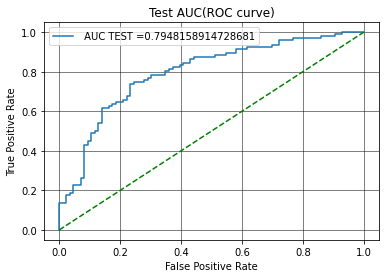

Finish 5-fold training


In [ ]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################
for fold in range(1, k_fold+1):
  model = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'GCN_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))
  
  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')


The best validation accuracy is  0.7241379310344828
The corresponding test accuracy is  0.6666666666666666
The corresponding test AUC is:  0.7167841828683164


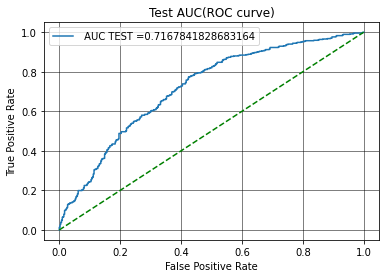

In [ ]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

Ensemble  1
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

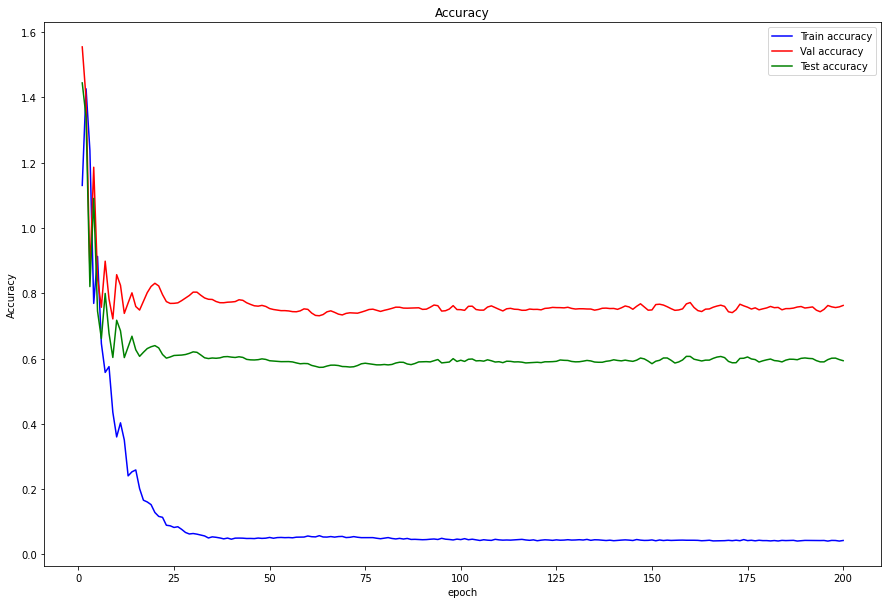

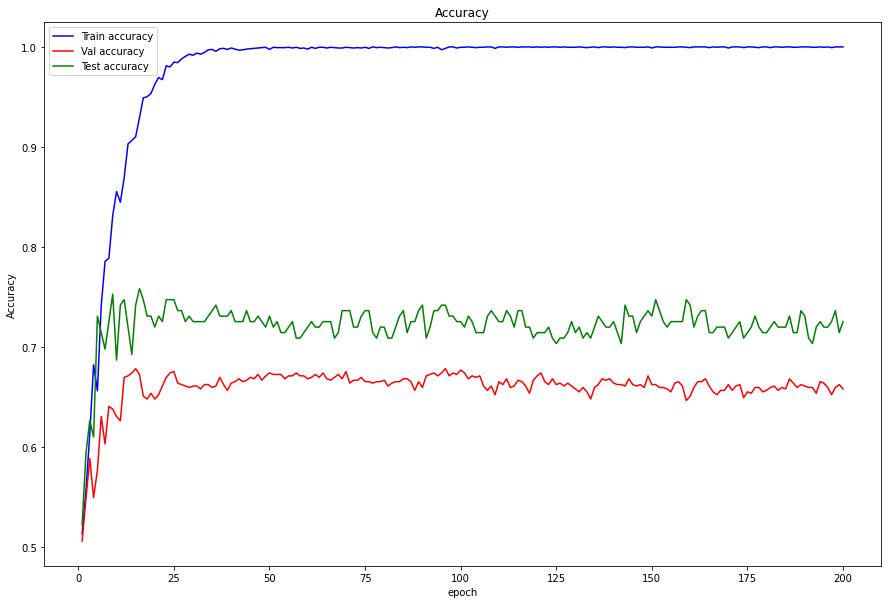



In ensemble  1
The best validaiton accuracy is:  0.6782608695652174
Happened at epoch:  96
The corresponding test accuracy 0.7417582417582418
The corresponding test AUC is:  0.8167393410852714




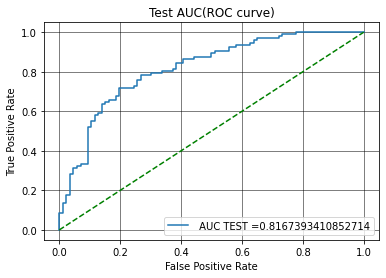



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

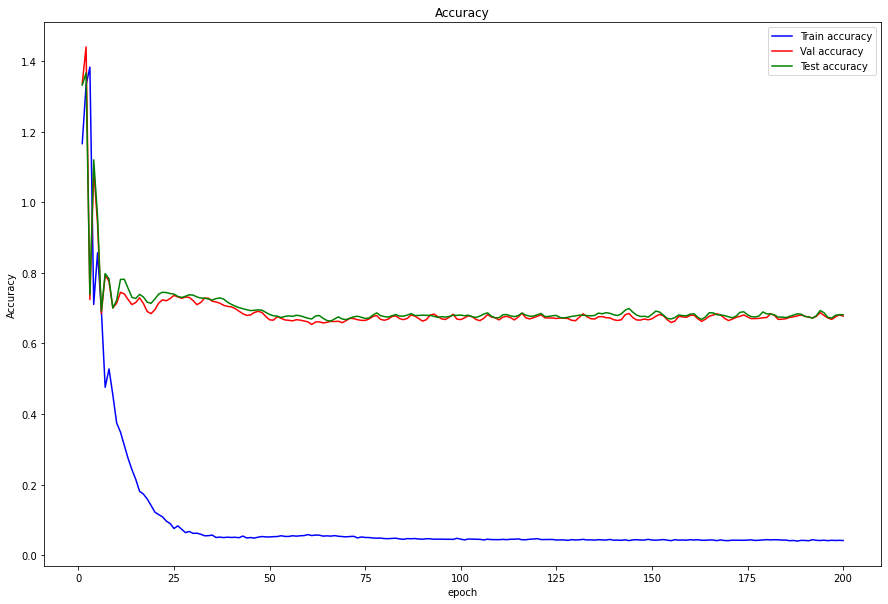

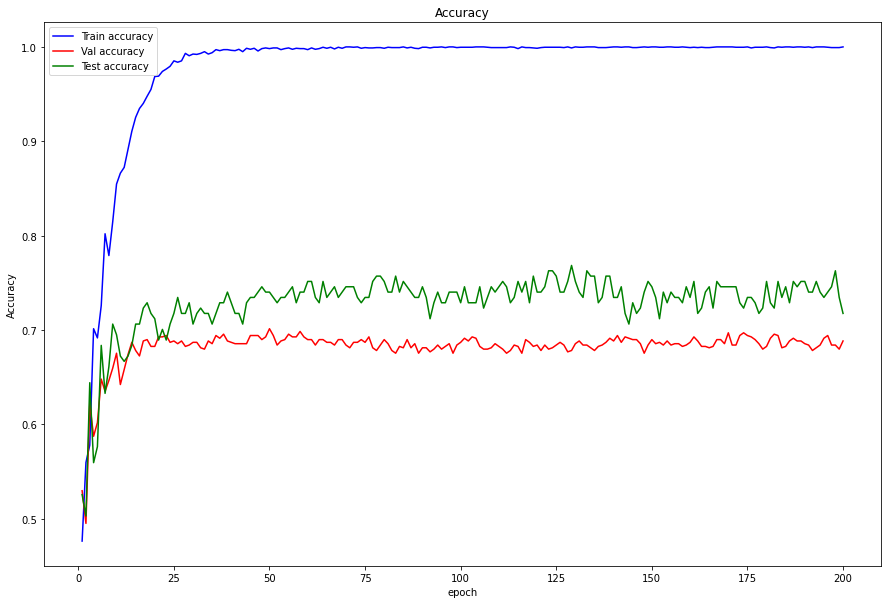



In ensemble  2
The best validaiton accuracy is:  0.7012987012987013
Happened at epoch:  50
The corresponding test accuracy 0.7401129943502824
The corresponding test AUC is:  0.7822250639386189




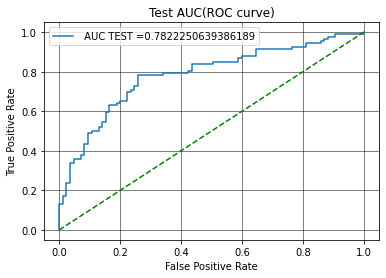



Ensemble  3
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

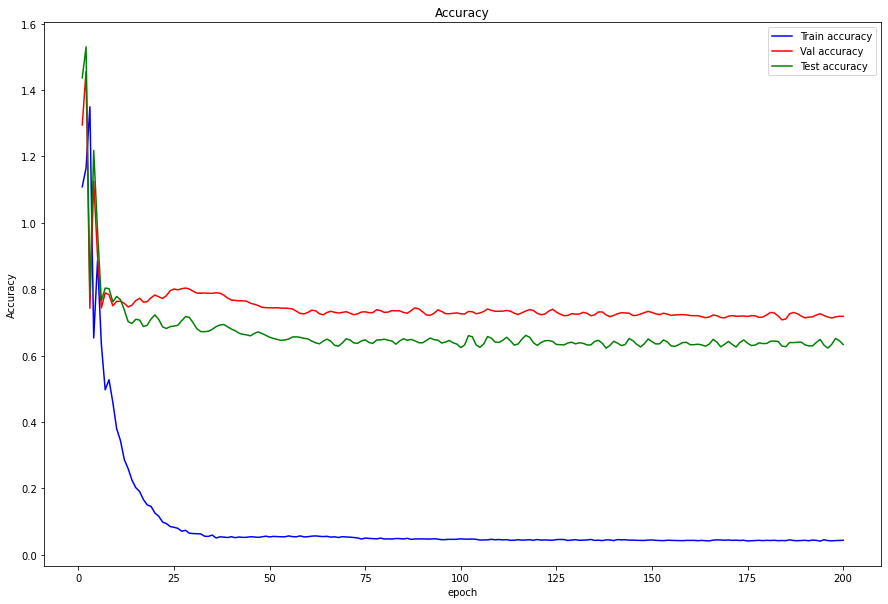

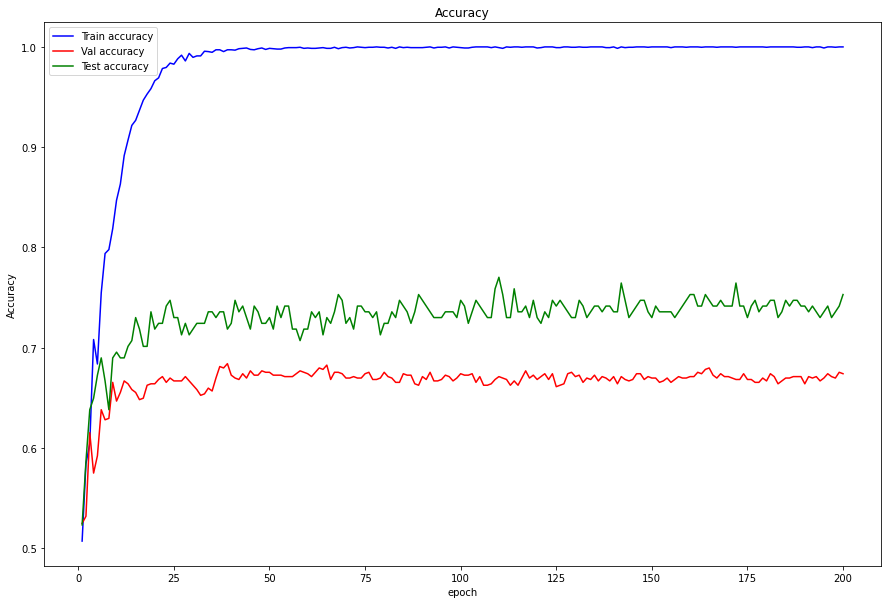



In ensemble  3
The best validaiton accuracy is:  0.6839080459770115
Happened at epoch:  39
The corresponding test accuracy 0.7183908045977011
The corresponding test AUC is:  0.7861409796893668




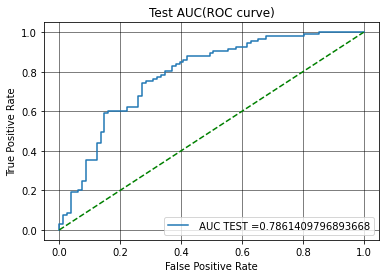



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

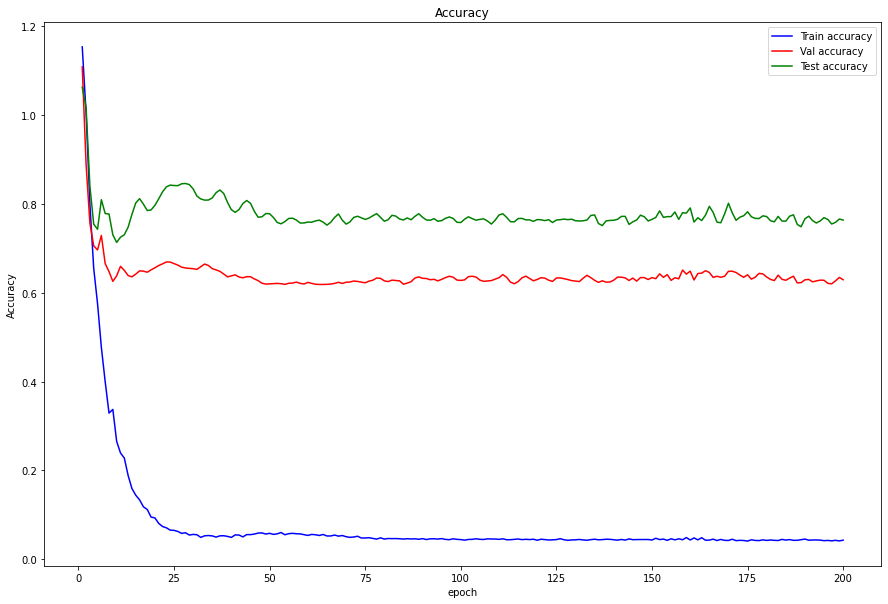

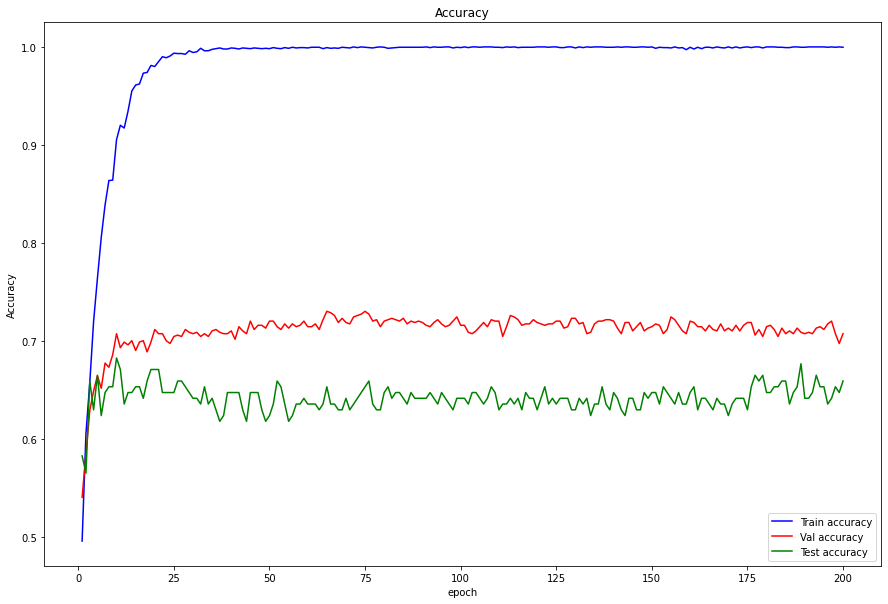



In ensemble  4
The best validaiton accuracy is:  0.73
Happened at epoch:  75
The corresponding test accuracy 0.6529411764705882
The corresponding test AUC is:  0.7095464725643897




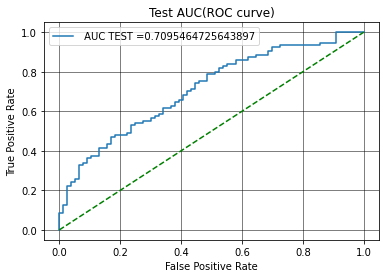



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

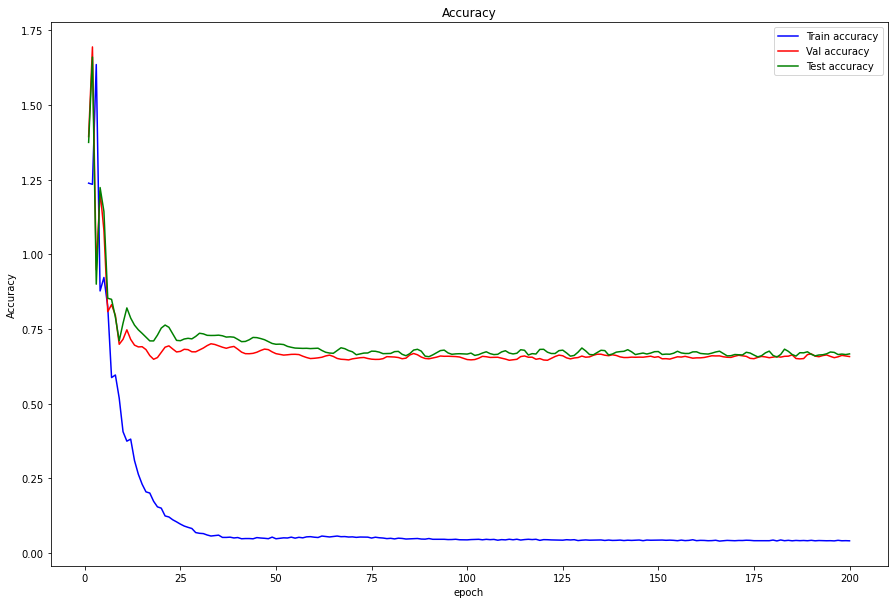

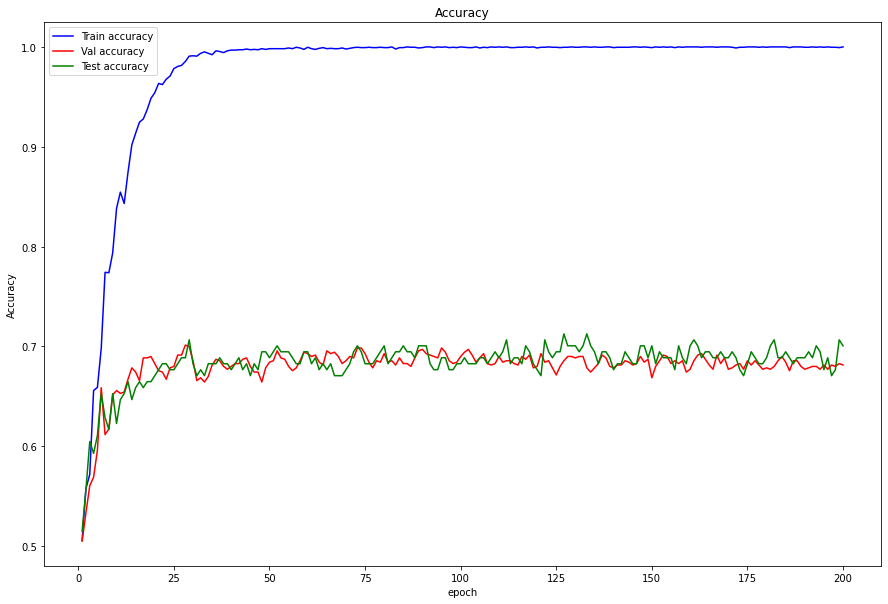



In ensemble  5
The best validaiton accuracy is:  0.701280227596017
Happened at epoch:  28
The corresponding test accuracy 0.688622754491018
The corresponding test AUC is:  0.778695652173913




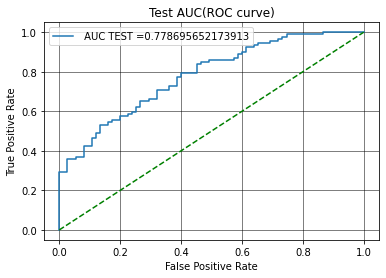



The Max voting test accuracy is:  0.7091954022988506
The test AUC is:  0.774092592494195






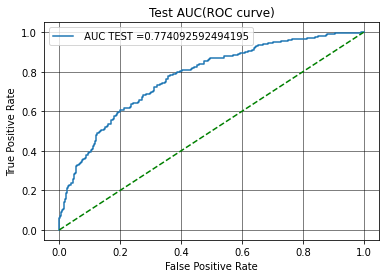

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/GCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  
  
  data = {}
  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector = feature_selection(fMRI_images, labels, dist_train[str(fold)], new_number_features)
    fold_data = selector.transform(fMRI_images)

    n = fold_data.shape[0]
    num_edge = n * n
    edge_index = np.zeros([2, num_edge], dtype=np.int64)
    edgenet_input = np.zeros([num_edge, 1], dtype=np.float32) 
    aff_score = np.zeros(num_edge, dtype=np.float32)
    flatten_ind = 0

    for i in range(n): 
      for j in range(n):
        edge_index[:, flatten_ind] = [i, j]
        edgenet_input[flatten_ind] = graph[i,j]
        aff_score[flatten_ind] = graph[i,j]
        flatten_ind += 1


    keep_ind = np.where(aff_score > 0.99)[0]
    edge_index = edge_index[:, keep_ind]
    edgenet_input = edgenet_input[keep_ind]

    data[str(fold)].append(fold_data)
    data[str(fold)].append(GCN_labels)
    data[str(fold)].append(edge_index)
    data[str(fold)].append(edgenet_input)




  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_2 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_3 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_4 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)
  model_5 = GCN(in_c=args.input_dimension, hid_c=args.hidden_dimension, out_c=args.output_dimension, K=args.cheby_order_K, dropout_rate=args.dropout_rate)

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_GCN

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr, weight_decay=0.1)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr, weight_decay=0.1)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'GCN_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
 
  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

